In [11]:
!pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.6 MB/s eta 0:00:00


In [12]:
# Import Modules
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
# Disable Warnings
import warnings
warnings.filterwarnings('ignore')
# Allow Multiple Output per Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
# StatsModels for Ordinary Least Squares Regresssion
import statsmodels.api as sm
# Import the adfuller (ADF) Stationarity Test
from statsmodels.tsa.stattools import adfuller
# Import QuantStats for Trading Strategy Tear-Sheets
import quantstats as qs

In [16]:
import pandas as pd
import yfinance as yf

# Define tickers
sp500 = '^GSPC'
google = 'GOOG'
tickers = [sp500, google]

# Define date range
start = '2020-01-01'
end = '2024-01-01'

# Create an empty DataFrame
df = pd.DataFrame()

# Download Adjusted Close Prices from Yahoo Finance
df[tickers[0]] = yf.download(tickers[0], start=start, end=end, progress=False)['Close']
df[tickers[1]] = yf.download(tickers[1], start=start, end=end, progress=False)['Close']

# Display DataFrame
print(df.head())


                  ^GSPC       GOOG
Date                              
2020-01-02  3257.850098  68.123726
2020-01-03  3234.850098  67.789421
2020-01-06  3246.280029  69.460922
2020-01-07  3237.179932  69.417580
2020-01-08  3253.050049  69.964615


Text(0, 0.5, '^GSPC')

Text(0, 0.5, 'GOOG')

Text(0.5, 1.0, '^GSPC vs GOOG')

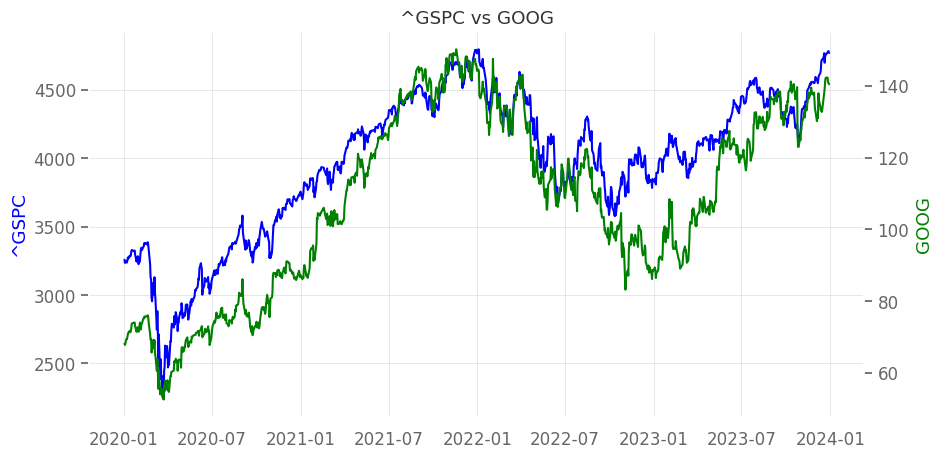

In [18]:
# Plot Market Data
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df[tickers[0]], color='blue')
plt.ylabel(tickers[0], color='blue')
ax1 = ax.twinx()
ax1.plot(df.index, df[tickers[1]], color='green')
plt.ylabel(tickers[1], color='green')
plt.grid()
plt.title(f'{tickers[0]} vs {tickers[1]}')
plt.show()

In [19]:
# Compute the Beta or hedge ratio between Y (Google) and X (S&P 500 Ind
Y = df[tickers[0]]
x = df[tickers[1]]
# Add Constant Intercept Term
X = sm.add_constant(x)
# Peform OLS
result = sm.OLS(Y,X).fit()
# Uncomment to View Summary
#result.summary()
# Beta or Hedge Ratio
hedge_ratio = result.params[1]
print(f'Hedge Ratio: {hedge_ratio:.4f}')

Hedge Ratio: 19.6678


In [20]:
# Compute the Spread
df['spread'] = Y - hedge_ratio * x
# Also Compute the Spread Log Return
df['log_return'] = np.log(df['spread']/df['spread'].shift(1))
# Uncomment to Display the Spread Data Frame
#df.head()

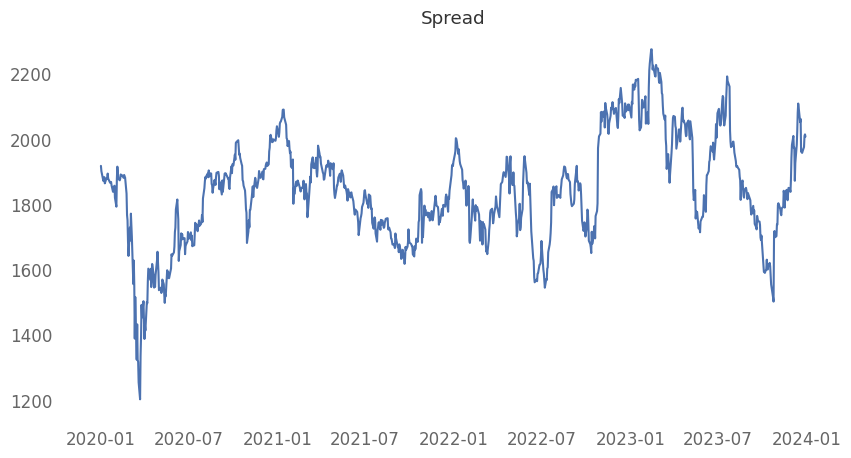

In [21]:
# Plot the Spread
fig = plt.figure(figsize=(10,5))
plt.plot(df['spread'])
plt.grid()
plt.title('Spread')
plt.show();

In [22]:
#  Test for Co-Integration or Stationarity

In [23]:
 # Test the Spread for Stationarity using ADF
adf = adfuller(df['spread'], maxlag=1)
# p-value
p_value = adf[1]
# Print ADF Results
print(f'ADF Result Parameters \n{adf}\n')
# Print Test Statistic
print(f'Test Statistic: {adf[0]:.4f}')
# Print Critical Value
print(f'Critical Value: {adf[4]["5%"]:.4f}')
# Print P-Value
print(f'P-Value: {adf[1]*100:.4f}%')

ADF Result Parameters 
(-3.33097256061968, 0.01354950604062298, 0, 1005, {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}, 9950.24940540745)

Test Statistic: -3.3310
Critical Value: -2.8644
P-Value: 1.3550%


In [24]:
# Method to Print Stationarity Result
def is_stationary(p_value):
  if (p_value<0.05):
    print(f'Series is Stationary (p-value {p_value*100:.4f}%)')
  else:
    print(f'Series NOT Stationary (p-value {p_value*100:.4f}%)')
  return
# Display Stationarity Result
is_stationary(p_value)

Series is Stationary (p-value 1.3550%)


Compute Z-Score
 We compute the normalized z-score as follows:
 Z-Score =
( (𝑥−𝜇)/𝜎)

In [25]:
 # Compute Mean and Std using window specified
window = 30
df['mean'] = df['spread'].ewm(span=window).mean()
df['std'] = df['spread'].ewm(span=window).std()
# Drop NaN Values
df.dropna(inplace=True)
# Compute the Z-Score
df['z_score'] = ( df['spread'] - df['mean'] ) / df['std']
# Z-Score Boundaries
df['z_up'] = 2.0
df['z_down'] = -2.0
# Uncomment to Display DataFrame
#df.head()

In [26]:
# Long Trading Signals
long_entry = (df['z_score'] <= df['z_down'])
long_exit = (df['z_score'] >= 0)
# Initialize Long Position Column to NaN
df['long_pos'] = np.nan
# Apply Long Trading Signals
df.loc[long_entry, 'long_pos'] = 1
df.loc[long_exit, 'long_pos'] = 0
# Forward Fill NaN Values
df['long_pos'].fillna(method='ffill', inplace=True)
# Fill any remaining NaN values wth Zero
df['long_pos'].fillna(0, inplace=True)

In [27]:
 # Short Trading Signals
short_entry = (df['z_score'] >= df['z_up'])
short_exit = (df['z_score'] <= 0)
# Initialize Short Position Column to NaN
df['short_pos'] = np.nan
# Apply Long Trading Signals
df.loc[short_entry, 'short_pos'] = -1
df.loc[short_exit, 'short_pos'] = 0
# Forward Fill NaN Values
df['short_pos'].fillna(method='ffill', inplace=True)
# Fill any remaining NaN values wth Zero
df['short_pos'].fillna(0, inplace=True)

In [28]:
# Total Trading Position
df['total_pos'] = df['long_pos'] + df['short_pos']
# Uncomment to Display DataFrame
#df.head()

Text(0, 0.5, 'Z-score')

Text(0, 0.5, 'Spread')

Text(0.5, 1.0, 'Z-Scores')

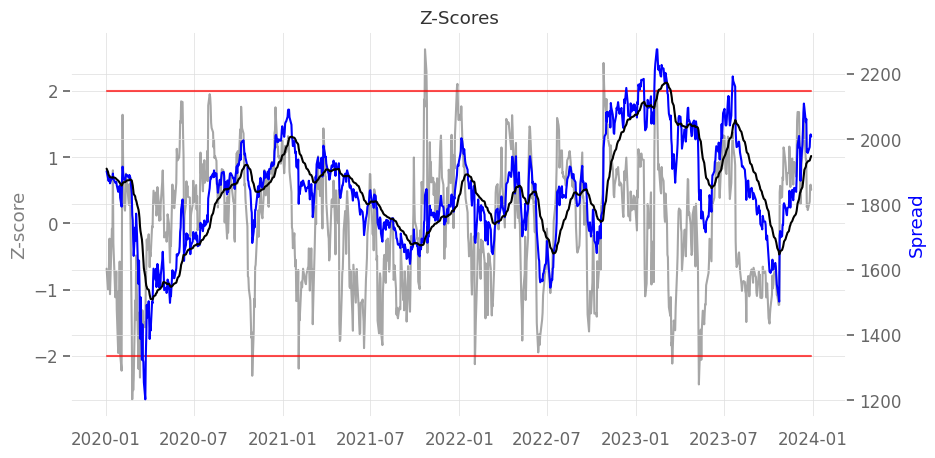

In [29]:
# Plot the Z-Scores
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df['z_score'], color='grey', alpha=0.7)
ax.plot(df.index, df['z_up'], color='red', alpha=0.7)
ax.plot(df.index, df['z_down'], color='red', alpha=0.7)
ax.set_ylabel('Z-score', color='grey')
ax1 = ax.twinx()
ax1.plot(df.index, df['spread'], color='blue')
ax1.plot(df.index, df['mean'], color='black')
ax1.set_ylabel('Spread', color='blue')
plt.title('Z-Scores')
plt.show()